# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).


In [101]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
#import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string


from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
from sklearn.model_selection import train_test_split
from mpl_toolkits import mplot3d
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import classification_report, confusion_matrix 
import seaborn as sns
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from wordcloud import WordCloud
import pandas

In [102]:
con = sqlite3.connect('data.sqlite') 
df = pd.read_sql_query(""" SELECT * FROM Reviews""", con) 
data=df['CleanedText'].head(100000)
label=df['Score'].head(100000)

In [103]:
vect=TfidfVectorizer(min_df=10,use_idf=True).fit(data)
tf=vect.transform(data)

Taking 100k datapoints, vectorized it using Tfidf vectorizer and taking only those words which have appeared at least 10 times.

## Truncated-SVD

### [5.1] Taking top features from TFIDF,<font color='red'> SET 2</font>

In [104]:
indices_desc=np.argsort(vect.idf_)[::] #sorting indices based on idf score.
indices_3k=list(indices_desc[:3000]) #taking top 3k words
dct={}
for i in indices_3k:
    dct[vect.get_feature_names()[i]]=vect.idf_[i]

In [105]:
top_words=list(dct.keys()) 

In [106]:
###function to get correct index if a word appaers more than once in a list
def numr(dctz,s): 
    for key,value in dctz.items():
        if key==s:
            return (value.pop(0))

### [5.2] Calulation of Co-occurrence matrix

In [182]:
def co_occurence_matrix(text,window_size,top_words): 
    shape=len(top_words)
    occ_matrix=np.zeros((shape,shape)) #initializing matrix 
    for i in text:   
        review_list=i.split()
        len_words=len(review_list)
        dctz={}
        for num in review_list:
            set_index=set()
            for p in range(len_words):
                if review_list[p]==num:
                    set_index.add(p)
            x=sorted(set_index)
            dctz[num]=x
        for t in review_list:
            word_index=numr(dctz,t) #to get index of word in review
            
            try:
                if t in top_words:
                    row=top_words.index(t)
                    if word_index < window_size and len_words >= (word_index+window_size+1):
                        neighbour=range(0,word_index+window_size+1)
                    elif word_index >=window_size and (word_index+window_size+1)<=len_words:
                        neighbour=range(word_index-window_size, word_index+window_size+1)
                    elif word_index+window_size+1 > len_words and len_words >=window_size :
                        neighbour=range(word_index-window_size,len_words)
                    elif word_index+window_size+1 > len_words and len_words <window_size :
                        neighbour=range(len_words)

                    for j in neighbour: 
                        c=review_list[j]
                        if c in top_words:
                            #print(c)
                            col=top_words.index(c)
                            occ_matrix[row][col]+=1
            except IndexError:
                print(i)
                print(review_list)
                print(neighbour)
                print(j)
                print(c)
    np.fill_diagonal(occ_matrix,0)
    return occ_matrix

In [183]:
#dummy data to check co-occurence matrix result
text=["abc def ijk pqr","pqr klm opq","lmn pqr xyz abc def pqr abc"]
top=["abc","pqr","def"]

In [185]:
co_occurence_matrix(text,2,top)


array([[0., 3., 3.],
       [3., 0., 2.],
       [3., 2., 0.]])

In [188]:
x=co_occurence_matrix(data,5,top_words)
#np.count_nonzero(x)


Steps for calculating Co-occurence matrix:
1) for every review in text, split words in review.
2) If the word is in top_words too,get index of the word(row).
3) For the word, get all the neighbour words within window_size.
4) If any of neighbour also exist in top words, get index(column).
5) Increase count of matrix[row][column] by 1.
6)Repeat the process for all reviews.

### [5.3] Finding optimal value for number of components (n) to be retained.

In [215]:
var=0
dctx={}
tsvd=TruncatedSVD(n_components=2999)  #fitting truncated SVD on co-occurence matrix
tsvd.fit(x)

var=0
dctp={}
for i in range(2999):
    var+=tsvd.explained_variance_ratio_[i] #cumilative sum of variances
    dctp[i]=var

Fitting the co-occurence matrix in TruncatedSVD and find optimal component which explain maximum variance but lower in dimension than original matrix.

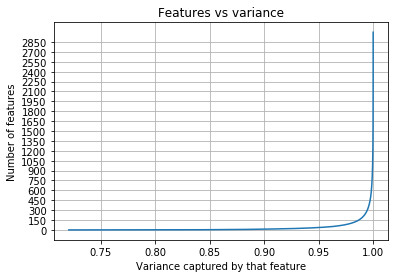

In [221]:
col=list(dctp.keys())
row=list(dctp.values())
plt.plot(row,col)
plt.ylabel('Number of features')
plt.xlabel("Variance captured by that feature")
plt.yticks(range(0,2999,150))
plt.title("Features vs variance")
plt.grid()
plt.show()

In [223]:
from sklearn.utils.extmath import randomized_svd
svd_optimal_component=TruncatedSVD(n_components=150)
u=svd_optimal_component.fit_transform(x) #u is the word vector mtrix where every row corresponds to a word 


Fitting Truncated svd with optimal number of component on co-occurence matrix and get the decompostion matrices i.e, U, sigma and V_transpose. 


### [5.4] Applying k-means clustering

#### To find optimal number of clusters

In [227]:
# %%time
error=[]
for k in range(1,150,4):
    model=KMeans(n_clusters=k)
    model.fit(u)
    error.append(model.inertia_)
# Please write all the code with proper documentation

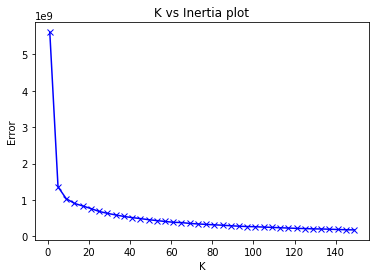

In [228]:
K=range(1,150,4)
plt.plot(K,error,'bx-')
plt.xlabel('K')
plt.ylabel('Error')
plt.title('K vs Inertia plot')
plt.show()

#### Fitting KMeans clustering on word vector matrix with optimal number of clusters.

In [229]:
clf=KMeans(n_clusters=5,random_state=0).fit(u)


### [5.5] Wordclouds of clusters obtained in the above section

In [238]:
##Function to get words belonging to a particular cluster and print them in wordcloud
def wordcloud_cluster(clf,cluster_no):
    lst=[]
    a=(np.where(clf.labels_==cluster_no)[0])
    for i in a:
        lst.append(top_words[i])
    string=(" ").join(lst)
    wordcloud=WordCloud().generate(string)
    print("Cluster {}:".format(cluster_no))
    plt.figure(figsize=(15,15))
    plt.imshow(wordcloud)
    plt.axis("off")
    
        

Cluster 0:


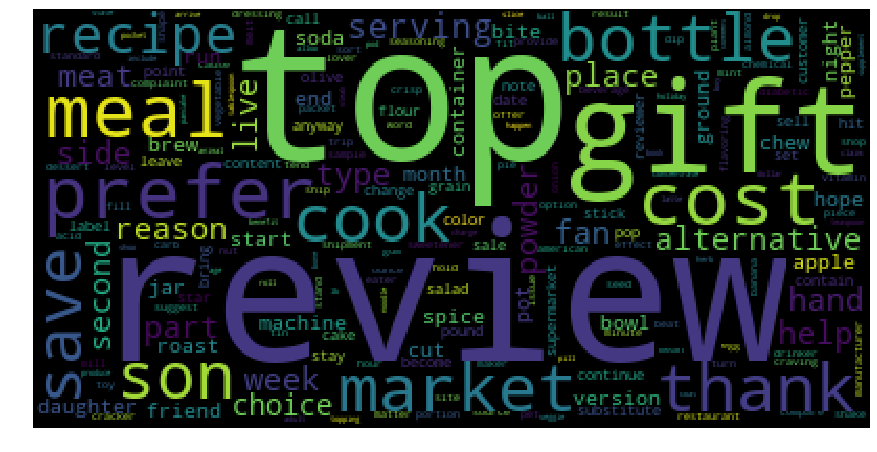

In [239]:
wordcloud_cluster(clf,0) #Wordcloud of all the words which belongs to cluster 0.

This cluster cointains general words related to shopping.

Cluster 1:


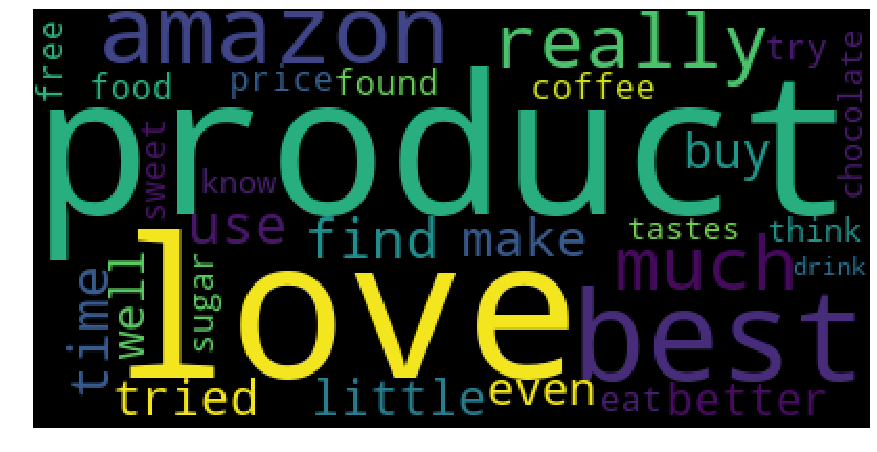

In [240]:
wordcloud_cluster(clf,1) # All words which belongs to cluster 1

Cluster 2:


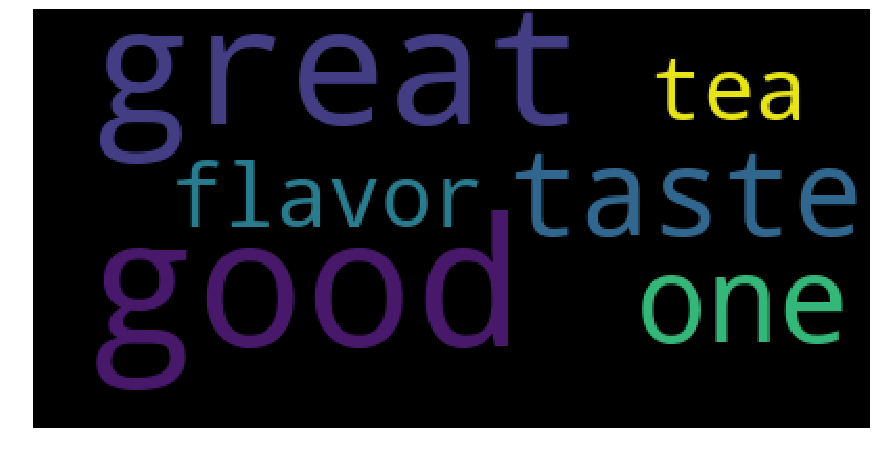

In [241]:
wordcloud_cluster(clf,2) #All words which belongs to cluster 2

This cluster basically defines adjectives seperating review classes.

Cluster 4:


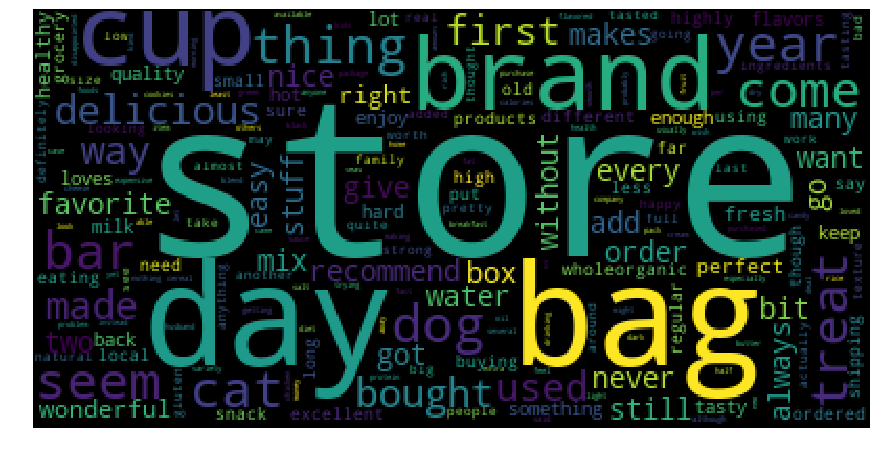

In [242]:
wordcloud_cluster(clf,4) #All words which belongs to cluster 3

This cluser is related to general and neutral words.

(-0.5, 399.5, 199.5, -0.5)

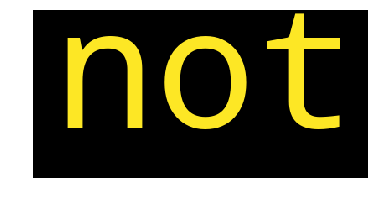

In [243]:
z=int(np.where(clf.labels_==3)[0]) #All words which belong to cluster 4 and last cluster
x=top_words[z]
words = pandas.Series({x:1})
wordcloud = WordCloud().fit_words(words)
plt.imshow(wordcloud)
plt.axis("off")

This cluster consists of just one word,'not', which is mostly included with negative reviews,

### [5.6] Function that returns most similar words for a given word.

In [247]:
#Function to get cosine similarity given two vectors
def cos_similarity(vec1,vec2):
    return (np.dot(vec1,vec2)/(magnitude(vec1)*  magnitude(vec2)))

#Function to get L2 norm of a vector.
def magnitude(x):
    return np.sqrt(np.dot(x,x))

In [258]:
# Given a word, function to find most similar word in whole matrix based on the value of cosine.
## To find the vector which has highest cosine value with query vector.


def most_similar_word(query_word, matrix):
    lstt=[]
    src=[]
    if query_word in top_words:
        query_index=top_words.index(query_word)
        query_vector=matrix[query_index]
        for i in range(matrix.shape[0]):
            if i!=query_index:
                p=cos_similarity(query_vector,matrix[i])
                #print(p)
                lstt.append(p)
        #print(lstt)
        sorted_list=np.argsort(lstt)[::-1] #sort the list based on incides in descending oreder
        #print(sorted_list)
        z=sorted_list[:10]
        #print(z)
        for p in z:
            src.append(top_words[p])
        return src
    else:
        print("Word didn't found in training database")
        

In [262]:
print(most_similar_word('review',u))
print(most_similar_word('excellent',u))
print(most_similar_word('amazing',u))

['went', 'company', 'research', 'heated', 'multiple', 'write', 'pork', 'disappeared', 'color', 'five']
['acid', 'simply', 'handful', 'cakes', 'great', 'wonderful', 'close', 'chai', 'fan', 'sold']
['simply', 'tree', 'close', 'wonderful', 'vegan', 'delicious', 'sodium', 'love', 'good', 'great']


# [6] Conclusions

here i took 100k words, applied tfidf vectorizer and took top 3k words based on idf score. Further, calculated co-occurence matrix of those 3k words in neighbourhood of 4 i.e., words which occurrs together frequently got higher value and thus, are closer to each other. Then, applied Truncated SVD on the co-occurence matrix and got word vector matrix, which composed of 3k words having dimension of 150 each(obtained by elbow method).

Further, applied KMeans on the word vector with optimal value K(obtained by K vs inertia_ graph) and found optimal number of cluster(5 here). Plotted wordcloud for each cluster.


At last, wrote a function which find 10 similar words in word vector matrix given a query word using cosine similarity.
Since, the word vector is constructed on basis on co-occurence matrix, so the cosine_similarity return the 10 words which has been most with query word.

Optimal value for number of components:150



Optimal number of cluster: 5